In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [2]:
# File paths
input_file = "C:\\Users\\Hp\\OneDrive\\Documents\\project\\SRU_Project\\data\\IN_Table.csv"
output_file = "C:\\Users\\Hp\\OneDrive\\Documents\\project\\SRU_Project\\data\\OUT_Table.csv"


# Read input and output data
data1 = pd.read_csv(input_file).to_numpy()
data2 = pd.read_csv(output_file).to_numpy()
data = np.hstack((data1, data2))


In [8]:
# Extract input-output matrices
input_count = 5
output_count = 2

input_matrix = data[:, 0:input_count]
output_matrix = data[:, 5:7]

# Split into training and validation sets (70%-30%)
num_samples = output_matrix.shape[0]
indices = np.random.permutation(num_samples)
train_size = int(0.7 * num_samples)
train_indices = indices[:train_size]
valid_indices = indices[train_size:]

train_input = input_matrix[train_indices]
train_output = output_matrix[train_indices]
valid_input = input_matrix[valid_indices]
valid_output = output_matrix[valid_indices]

# Combine train data for easier indexing
train_data = np.hstack((train_input, train_output))
valid_data = np.hstack((valid_input, valid_output))


In [9]:
output_matrix.shape[0]

14401

In [18]:
# Number of nearest neighbors
k = 60

# Initialize prediction matrix
y_predict_lin = np.zeros((len(valid_output), output_count))

# Build Nearest Neighbors model (Euclidean distance)
nn_model = NearestNeighbors(n_neighbors=k, metric='euclidean')
nn_model.fit(train_input)

# JIT Modeling and Prediction
for i, query_point in enumerate(valid_input):
    distances, indices = nn_model.kneighbors([query_point])
    neighbor_input = train_data[indices[0], 0:input_count]
    neighbor_output = train_data[indices[0], 5:7]
    
    # Remove missing values if any
    neighbor_input = neighbor_input[~np.isnan(neighbor_input).any(axis=1)]
    neighbor_output = neighbor_output[~np.isnan(neighbor_output).any(axis=1)]

    if neighbor_input.size == 0 or neighbor_output.size == 0:
        y_predict_lin[i, :] = np.nan
        continue

    # Fit separate linear models for each output
    model1 = LinearRegression().fit(neighbor_input, neighbor_output[:, 0])
    model2 = LinearRegression().fit(neighbor_input, neighbor_output[:, 1])

    y_predict_lin[i, 0] = model1.predict([query_point])
    y_predict_lin[i, 1] = model2.predict([query_point])


C:\Users\Hp\AppData\Local\Temp\ipykernel_18956\4121092214.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_predict_lin[i, 0] = model1.predict([query_point])
C:\Users\Hp\AppData\Local\Temp\ipykernel_18956\4121092214.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_predict_lin[i, 1] = model2.predict([query_point])
C:\Users\Hp\AppData\Local\Temp\ipykernel_18956\4121092214.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_predict_lin[i, 0] = model1.pre

In [19]:
# Compute Mean Squared Error
mean_error = np.nanmean((valid_output - y_predict_lin) ** 2, axis=0)
print("The mean error for trained model is:", mean_error)

# Compute R-squared
R_squared = []
for j in range(output_count):
    R_squared.append(r2_score(valid_output[:, j], y_predict_lin[:, j]))
print("The R-squared for trained model is:", R_squared)

# Compute error from mean
error = output_matrix - mean_error

The mean error for trained model is: [0.33552517 0.45856587]
The R-squared for trained model is: [0.6783967528581389, 0.5383204150349888]


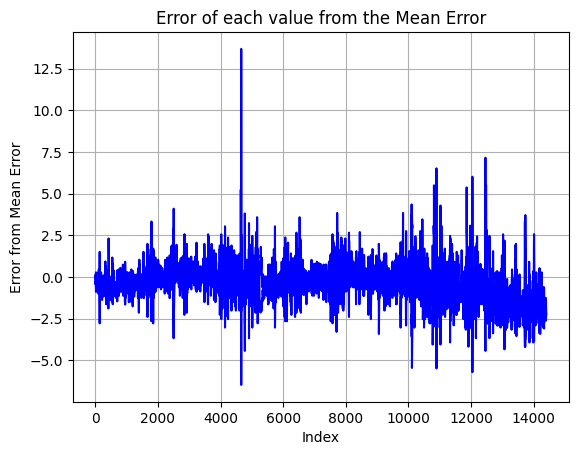

In [6]:
# Plot: Error from Mean Error
plt.figure()
plt.plot(range(len(output_matrix)), error, 'b', linewidth=1.5)
plt.xlabel('Index')
plt.ylabel('Error from Mean Error')
plt.title('Error of each value from the Mean Error')
plt.grid(True)
plt.show()

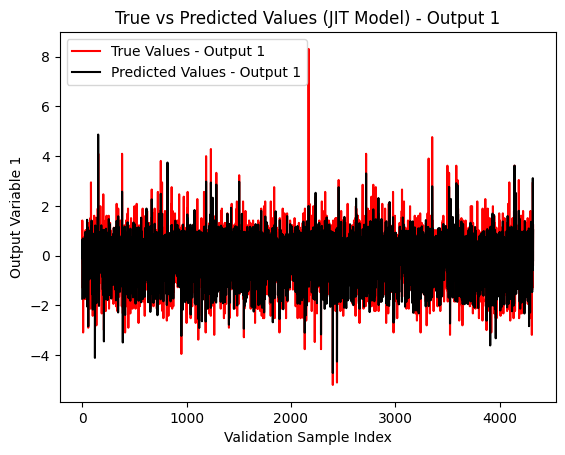

In [7]:
# Plot: True vs Predicted Output 1
plt.figure()
plt.plot(range(len(valid_output)), valid_output[:, 0], 'r', label='True Values - Output 1')
plt.plot(range(len(valid_output)), y_predict_lin[:, 0], 'k', label='Predicted Values - Output 1')
plt.xlabel('Validation Sample Index')
plt.ylabel('Output Variable 1')
plt.title('True vs Predicted Values (JIT Model) - Output 1')
plt.legend()
plt.show()

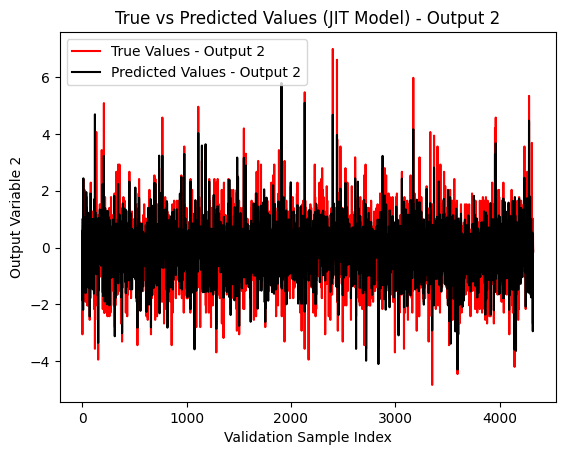

In [9]:
# Plot: True vs Predicted Output 2
plt.figure()
plt.plot(range(len(valid_output)), valid_output[:, 1], 'r', label='True Values - Output 2')
plt.plot(range(len(valid_output)), y_predict_lin[:, 1], 'k', label='Predicted Values - Output 2')
plt.xlabel('Validation Sample Index')
plt.ylabel('Output Variable 2')
plt.title('True vs Predicted Values (JIT Model) - Output 2')
plt.legend()
plt.show()